# Clustering Model on Affinity Graphs

In [1]:
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

import networkx as nx

from sknetwork.embedding import GSVD
from sknetwork.clustering import KMeans

from IPython.display import SVG
from sknetwork.visualization import svg_graph
from sklearn.metrics.cluster import contingency_matrix as contingency

## 1. Load Affinity Graph

In [2]:
A = nx.read_gexf('../graphs/fused_affinity_network_K=20_alpha=0.1750_beta=0.1750_t=2.gexf')
sites = ['STOMACH', 'LARGE_INTESTINE', 'BREAST', 'LUNG', 'PANCREAS', 'KIDNEY', 'SKIN', 'OVARY', 'URINARY_TRACT']

In [3]:
sites = ['LUNG']
selected_nodes = [n for n,v in A.nodes(data=True) if v['primary_site'] in sites]
H = A.subgraph(selected_nodes)

# create a sparse representation of the network by deleting edges
selected_edges = [(u,v) for u,v,e in H.edges(data=True) if e['weight'] >= 0.0]
G = H.edge_subgraph(selected_edges)

In [4]:
print("Samples with lung cancer type:",len(list(G.nodes())))

Samples with lung cancer type: 172


## 2. Prepare Histology & Subtypes Labels

|   Cancer Type	| Disease Type  	|   Subtype	|   Total	|
|---	|---	|---	|---	|
|   **Breast**	|   ductal carcinoma	|   24	|   **48**	|
|   	|   mataplastic carcinoma	|   1	|   	|
|   	|   *unspecified carcinoma*	|   23	|   	|
|   **Kidney**	|   renal_cell_carcinoma	|   7	|   **23**	|
|   	|   clear cell carcinoma	|   8	|   	|
|   	|   *unspecified carcinoma*	|   8	|   	|
|   **Lung**	|  small_cell_carcinoma 	|   37	|   **172**	|
|   	|   adenocarcinoma	|   39	|   	|
|   	|   squamous_cell_carcinoma	|   21	|   	|
|   	|   large_cell_carcinoma	|   12	|   	|
|   **Pancreas**	|   ductal carcinoma	|   22	|   **40**	|
|   	|   *unspecified carcinoma*	|   18	|   	|
|   **Skin**	|   malignant melanoma	|   45	|   **48**	|
|   	|   *unspecified melanoma*	|   4	|   	|

Table 1: CCLE multi-omics dataset

In [6]:
y = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [24]:
y[y.primary_site == "LUNG"].ccle_hist_subtype_1.value_counts()

adenocarcinoma                       39
small_cell_carcinoma                 37
nan                                  34
non_small_cell_carcinoma             21
squamous_cell_carcinoma              21
large_cell_carcinoma                 12
bronchioloalveolar_adenocarcinoma     4
mixed_adenosquamous_carcinoma         3
undifferentiated_carcinoma            1
Name: ccle_hist_subtype_1, dtype: int64

In [7]:
y = y[y.ccle_hist_subtype_1.isin(["adenocarcinoma", "small_cell_carcinoma"])]

In [8]:
y_labels = y.ccle_hist_subtype_1.values
y_cat = np.unique(y_labels, return_inverse=True)

In [9]:
y_cat

(array(['adenocarcinoma', 'small_cell_carcinoma'], dtype=object),
 array([0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0]))

## 3. Prepare the Data as an Affinity Graph

In [10]:
from scipy.sparse import csr_matrix

W = nx.to_pandas_adjacency(G)
W = W[y.index.values].T[y.index.values]
X = csr_matrix(W, dtype=np.float64)

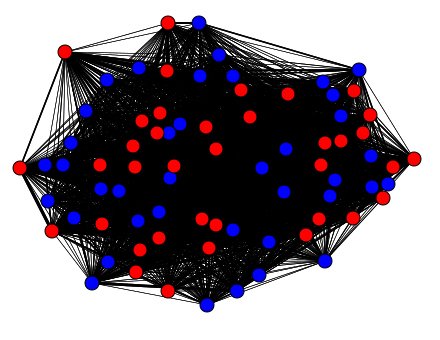

In [12]:
# Spring layout: Fruchterman-Reingold force directed layout
position = np.stack([x[1] for x in list(nx.spring_layout(G).items())])
image = svg_graph(X, position, labels=y_cat[1])
SVG(image)

## 4. K-Means Model

In [13]:
gsvd = GSVD(2, normalized=False)
kmeans = KMeans(n_clusters=2, embedding_method=gsvd)

embd_gsvd = gsvd.fit_transform(X)
y_pred = kmeans.fit_transform(X)

def purity(y_labels, y_pred):
    contingency_matrix = contingency(y_labels, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# soft clustering (here probability of label 1)
scores = kmeans.membership_[:,1].toarray().ravel()
print("Purity: {:.4f}".format(purity(y_labels, y_pred)))
pd.DataFrame(contingency(y_labels, y_pred), index=y_cat[0])

Purity: 0.8684


,0,1
adenocarcinoma,37,2
small_cell_carcinoma,8,29


In [14]:
pickle.dump(kmeans, open("../models/kmeans_kidney_AC-SCLC.joblib", 'wb'))
kmeans

KMeans(n_clusters=2, embedding_method=GSVD(n_components=2, regularization=None, factor_row=0.5, factor_col=0.5, factor_singular=0.0, normalized=False, solver=LanczosSVD(n_iter=None, tol=0.0)), co_cluster=False, sort_clusters=True, return_membership=True, return_aggregate=True)

## 5. Inspect Modelling Results

External information is used to verify the clusters in the lung cancer test set. T-SNE can be used to visualize a higher dimensional embedding in a simple plot.

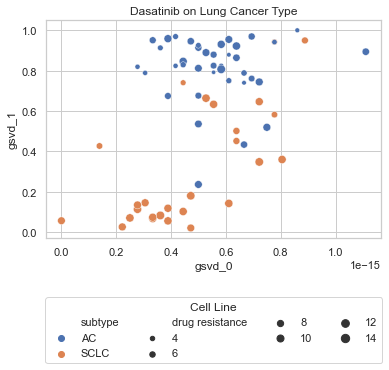

In [15]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
tsne = TSNE(n_components=2, random_state=0)

# use t-sne to visualize higher dimensions
scaled_gsvd = scaler.fit_transform(embd_gsvd)
# X_2d = tsne.fit_transform(scaled_gsvd)

cancer_type = pd.DataFrame({'label':y['label'],
    'gsvd_0':scaled_gsvd[:,0], 'gsvd_1':scaled_gsvd[:,1],
    'subtype':y['ccle_hist_subtype_1'], 'drug resistance':y['dasatinib']})

cancer_type = cancer_type.replace({"subtype": 
    {"small_cell_carcinoma":"SCLC", "adenocarcinoma":"AC"}
    })

plt.title('Dasatinib on Lung Cancer Type')
ax = sns.scatterplot(x="gsvd_0", y="gsvd_1", size="drug resistance", hue="subtype", data=cancer_type)
plt.legend(title="Cell Line", loc='upper center', bbox_to_anchor=[0.5, 1.25],columnspacing=1.3, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, -.6),
    ncol=4,
    title="Cell Line",
    frameon=True
)
plt.xlabel('gsvd_0')
plt.ylabel('gsvd_1')
plt.savefig('../figures/ANF_fused_lung_embedding_GSVD.png', dpi=500, bbox_inches='tight')
plt.show()

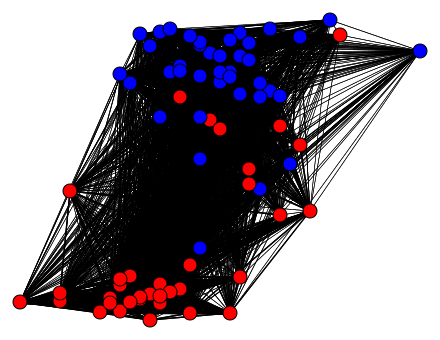

In [16]:
# visualize the embedding as a graph
image = svg_graph(X, embd_gsvd, labels=y_cat[1])
SVG(image)

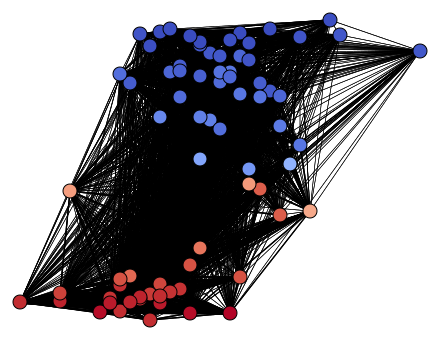

In [17]:
# visualize the cluster assignment probs
image = svg_graph(X, embd_gsvd, scores=scores)
SVG(image)

## 4. Perform Cluster Validation

We can measure the significance of the clustering against a random baseline to validate the patterns $C_1$ and $C_2$ in the affinity network using a randomization test $w(e) \sim ANF(K,\alpha,\beta)$.

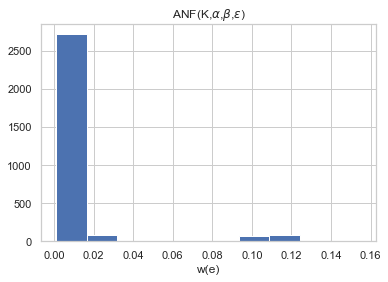

In [18]:
plt.title('ANF(K,$\\alpha$,$\\beta$,$\epsilon$)')
edges = nx.to_pandas_edgelist(G)
plt.xlabel('w(e)')
edges.weight.hist()
plt.show()

In [19]:
def shuffle_sparse(X):
    index = np.arange(np.shape(X)[0])
    np.random.shuffle(index)
    return X[index, :]

In [28]:
purities = []

for i in range(100):
    X_random = shuffle_sparse(X)

    gsvd = GSVD(2, normalized=False)
    kmeans = KMeans(n_clusters=2, embedding_method=gsvd)

    embd_gsvd = gsvd.fit_transform(X_random)
    y_pred = kmeans.fit_transform(X_random)

    scores = kmeans.membership_.toarray()
    purities.append(purity(y_labels, y_pred))

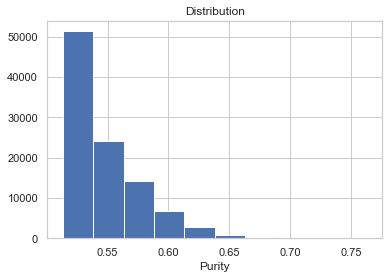

In [ ]:
plt.title("Distribution")
plt.hist(np.array(purities))
plt.xlabel("Purity")
plt.show()

In [ ]:
print("p-value (randomization):", (np.sum(np.array(purities) > 0.87)+1)/len(purities))

p-value (randomization): 1e-05
